In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras 
from tensorflow.keras import layers 

In [4]:
import numpy as np 
import pandas as pd 

In [5]:
import matplotlib.pyplot as plt 

In [6]:
import sklearn.preprocessing 

In [7]:
from sklearn.metrics import r2_score

In [8]:
url = 'https://raw.githubusercontent.com/Shubhrass/time_series_prediction_univar/main/DOM_hourly.csv' 
df = pd.read_csv(url)


In [9]:

#uncomment the following line for generating daily data 
#df = df[df['Datetime'].str.contains("00:00:00")]

df['Datetime'] = pd.to_datetime(df.Datetime,format='%Y-%m-%d %H:%M:%S')

df.index = df.Datetime

df.drop(['Datetime'], axis = 1, inplace = True)
df = df.sort_index()
df.head()


,DOM_MW
Datetime,
2005-05-01 01:00:00,7190.0
2005-05-01 02:00:00,6803.0
2005-05-01 03:00:00,6583.0
2005-05-01 04:00:00,6452.0
2005-05-01 05:00:00,6445.0


In [10]:
#checking missing data

df.isna().sum()


DOM_MW    0
dtype: int64

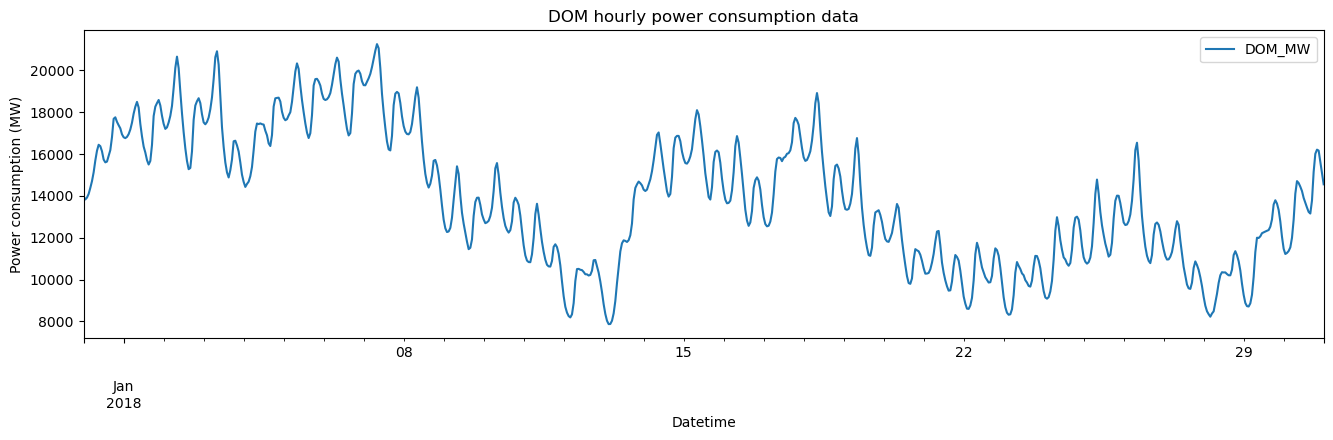

In [11]:
#@title Date Range

a= '2017-12-31' #@param {type: "date"}

b= '2018-01-31' #@param {type:"date"}
a=a+" 00:00:00"

b=b+" 00:00:00"

df.loc[a:b].plot(figsize = (16,4), legend = True)

plt.title('DOM hourly power consumption data')

plt.ylabel('Power consumption (MW)')

plt.show()


In [12]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df['DOM_MW']. values.reshape(-1,1))


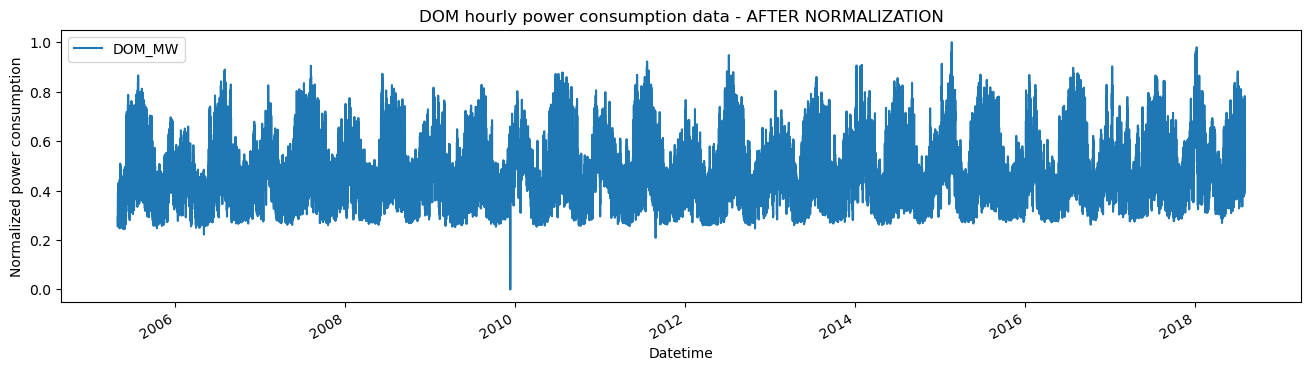

In [13]:
df.plot(figsize = (16,4), legend = True) 
plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')
plt.ylabel('Normalized power consumption')
plt.show()


In [14]:
def load_data(stock, seq_len):

    X_train = []

    y_train = []

    for i in range(seq_len, len(stock)):

        X_train.append(stock.iloc[i-seq_len: i, 0]) 
        y_train.append(stock.iloc[i, 0])

    X_test = X_train [int(0.9*(len(stock))):]

    y_test = y_train [int(0.9*(len(stock))):]

    X_train = X_train [: int(0.9*(len(stock)))]

    y_train = y_train [: int(0.9*(len(stock)))]

    # convert to numpy array

    X_train= np.array(X_train)

    y_train = np.array(y_train)

    X_test = np.array(X_test)

    y_test = np.array(y_test)

    # reshape data to input into RNN models…
    X_train = np.reshape(X_train,(X_train.shape[0],seq_len,1))
    X_test = np.reshape(X_test,(X_test.shape[0],seq_len,1))
    return [X_train, y_train, X_test, y_test]
    

In [15]:
#create train, test data

seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data (df, seq_len)

print('X_train.shape = ', X_train.shape)

print('y_train.shape = ', y_train.shape)

print('X_test.shape = ', X_test.shape)

print('y_test.shape = ',y_test.shape)

X_train.shape =  (104570, 20, 1)
y_train.shape =  (104570,)
X_test.shape =  (11599, 20, 1)
y_test.shape =  (11599,)


In [16]:
batch_size = 256
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_data = train_data.cache().shuffle(buffer_size). batch(batch_size).repeat()

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_data = test_data.batch(batch_size).repeat()

rnn_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape =X_train.shape[-2:]),tf.keras.layers.Dense(1)])

tf.keras.utils.plot_model(rnn_model)

rnn_model.compile(optimizer = 'adam', loss = 'mae')

In [21]:
EVALUATION_INTERVAL = 100
EPOCHS = 20
rnn_model.fit(train_data, epochs = EPOCHS, steps_per_epoch = EVALUATION_INTERVAL, validation_data = test_data, validation_steps = 50)

rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test, rnn_predictions)

print("R2 Score of RNN model = "+"{:.4f}".format(rnn_score));

#@title Data Range 
a = 0 #@param {type:"slider", min:0, max: 12000, step:1}

b = 12000 #@param {type:"slider", min:0, max: 12000, step:1}

Epoch 1/20
100/100 [==============================] - 4s 31ms/step - loss: 0.0121 - val_loss: 0.0104
Epoch 2/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0116 - val_loss: 0.0103
Epoch 3/20
100/100 [==============================] - 2s 24ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 4/20
100/100 [==============================] - 2s 17ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 5/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 6/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 7/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 8/20
100/100 [==============================] - 2s 24ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 9/20
100/100 [==============================] - 3s 29ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 10/20
100/100 [==============================] - 3s 27ms/step - loss: 0.0101 - val_lo

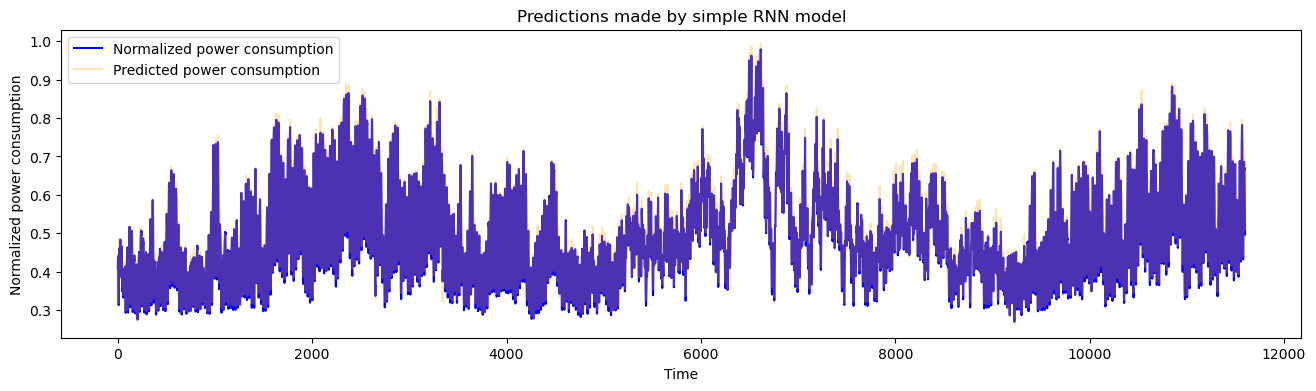

In [22]:
#@title Data Range 
a = 0 #@param {type:"slider", min:0, max: 12000, step:1}

b = 12000 #@param {type:"slider", min:0, max: 12000, step:1}
def plot_predictions (test, predicted, title):

    plt.figure(figsize = (16,4))

    plt.plot(test[a:b], color = 'blue', label = 'Normalized power consumption')

    plt.plot(predicted[a:b], alpha = 0.3,color = 'orange', label = 'Predicted power consumption')

    plt.title(title)

    plt.xlabel('Time')

    plt.ylabel('Normalized power consumption')
    plt.legend()
    plt.show()
plot_predictions(y_test,rnn_predictions,"Predictions made by simple RNN model")

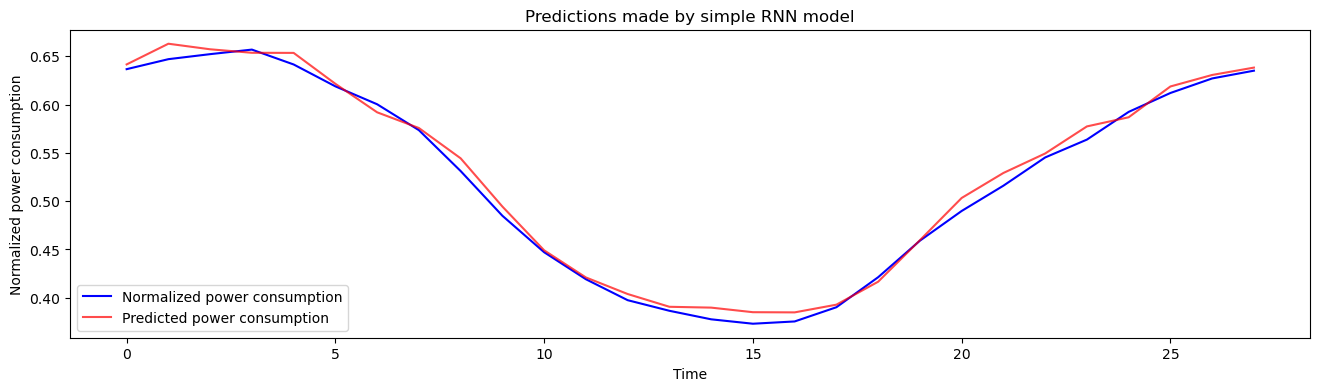

In [23]:
#@title Data Range
a = 3069 #@param {type:"slider", min:0, max:12000, step:1}
b = 3097 #@param {type:"slider", min:0, max:12000, step:1}
 
def plot_predictions(test, predicted, title):
   plt.figure(figsize=(16,4))
   plt.plot(test[a:b], color='blue',label='Normalized power consumption')
   plt.plot(predicted[a:b], alpha=0.7, color='red',label='Predicted power consumption')
   plt.title(title)
   plt.xlabel('Time')
   plt.ylabel('Normalized power consumption')
   plt.legend()
   plt.show()
  
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")
     

length of plottinf values  50
type of plotting values <class 'list'>


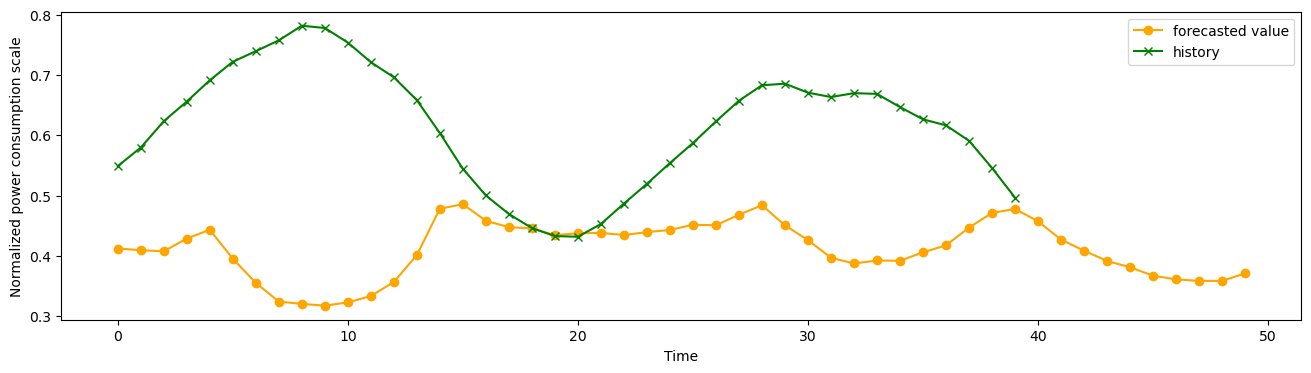

In [24]:
a  = 0
b = 90

history_data = list(y_test[-40:])
#rnn_list = .tolist()
#print("type of rnn list",type(rnn_list))
plottingvalues = list(rnn_predictions[:50])
print("length of plottinf values ",len(plottingvalues))
print("type of plotting values",type(plottingvalues))
plt.figure(figsize = (16,4))

plt.plot(plottingvalues[-90:], color = 'orange', label = 'forecasted value', marker = 'o')

plt.plot(y_test[-40:], color = 'green', label = 'history', marker = 'x')

plt.xlabel('Time')

plt.ylabel('Normalized power consumption scale')

plt.legend()

plt.show()

In [27]:
X = X_test[-1:]

In [28]:
rnn_predictions1 = rnn_model.predict(X)

1/1 [==============================] - 0s 109ms/step


In [30]:
rnn_predictions1

array([[0.5084115]], dtype=float32)

In [31]:
history_data = list(y_test[-40:]) 

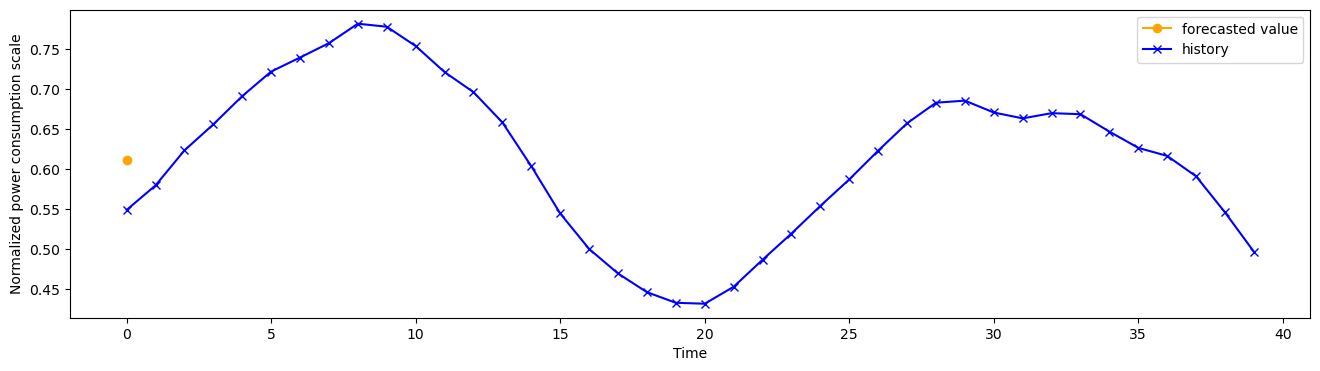

In [38]:
plottingvalues = list(rnn_predictions1)
plt.figure(figsize=(16,4))
plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
plt.plot(y_test[-40:], color='blue',label='history',marker='x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [33]:
history_data = list(y_test[-40:])

In [34]:
def make_data(X,rnn_predictions1):
  val = list(X[0][1:])+list(rnn_predictions1)
  X_new = []
  X_new.append(list(val))
  X_new = np.array(X_new)
  return X_new
     

In [35]:
forecast = list()

In [36]:
X = X_test[-1:]
     

In [37]:
for i in range (25):
  X = make_data(X,rnn_predictions1)
  rnn_predictions1 = rnn_model.predict(X)
  forecast += list(rnn_predictions1)

1/1 [==============================] - 0s 109ms/step


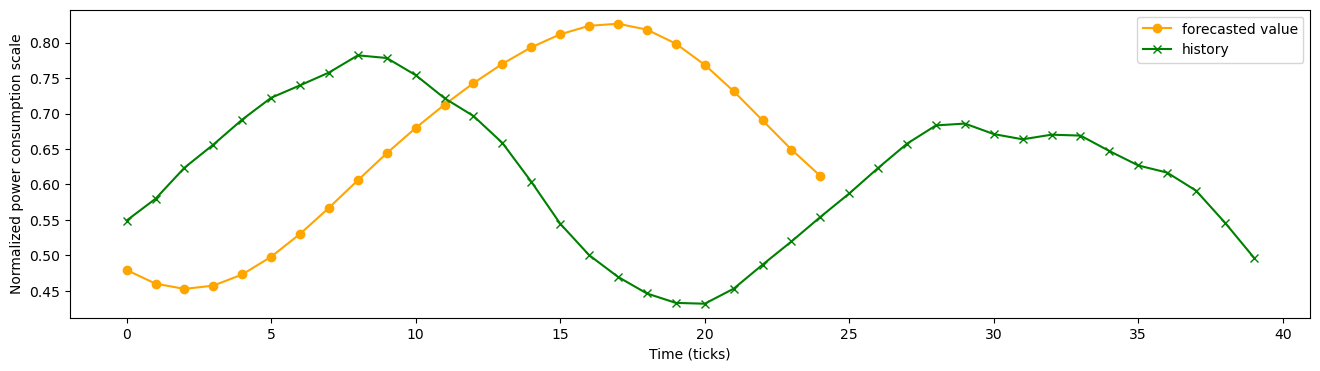

In [40]:
plottingvalues = list(forecast)
plt.figure(figsize=(16,4))
plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
plt.plot(y_test[-40:], color='green',label='history',marker='x')
plt.xlabel('Time (ticks)')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()